# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

data_location = '/data/data-with-embeddings/not-contextualized-embeddings/XLING'

processed_amazon_english_data_location = root + data_location + '/amazon_english.json'
processed_amazon_german_data_location = root + data_location + '/amazon_german.json'
processed_organic_data_location = root + data_location + '/organic.json'

embedding_dim = 512

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def read_data(processed_data_location):
  if processed_data_location is None:
    return None

  with open(processed_data_location) as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

In [21]:
amazon_en_df = read_data(processed_amazon_english_data_location)

In [22]:
amazon_de_df = read_data(processed_amazon_german_data_location)

In [23]:
organic_df = read_data(processed_organic_data_location)

In [24]:
def drop(df, column, value):
  print(f'----> size before {len(df)}')
  idx = df[column] != value
  print(f'----> size after {idx.sum()}')
  return df[idx]

drop_neutral = True

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('amazon_en')
  amazon_en_df = drop(amazon_en_df, 'comment_sentiment', '0')
  print('amazon_de')
  amazon_de_df = drop(amazon_de_df, 'comment_sentiment', '0')
  print('organic')
  organic_df = drop(organic_df, 'sentence_sentiment', '0')

======DROPPING NEUTRAL CLASS======
amazon_en
----> size before 129882
----> size after 115464
amazon_de
----> size before 28991
----> size after 23115
organic
----> size before 5084
----> size after 3111


In [25]:
if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'} 

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=1):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]
    if sentiment == 'p' and random.random() > downsampling_factor:
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
  sentiments = torch.Tensor(sentiments).to(device)

  return sentiment_dataset, sentiments

amazon_en_dataset, amazon_en_sentiments = parse_amazon_data(amazon_en_df, 0.15)
amazon_de_dataset, amazon_de_sentiments = parse_amazon_data(amazon_de_df)

In [26]:
organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':last_column].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)
organic_dataset = dataset.DocumentDataset(tuple(organic_embeddings.unsqueeze(1)),
                                          organic_sentiments)

In [27]:
datasets = {'amazon_en' : amazon_en_dataset, 'amazon_de': amazon_de_dataset,
            'organic': organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 3273
len(amazon_de) = 7864
len(organic) = 3111


In [28]:
full_stats = amazon_en_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_en_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1372; after downsampling -> 1372
sentiment "p":
	before downsampling -> 12605; after downsampling -> 1901


In [ ]:
def split(dataset_to_split, splits=(0.8, 0.1, 0.1)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_test = int(splits[2] * n_comments)
  n_train = n_comments - n_val - n_test

  return utils.data.random_split(dataset_to_split, (n_train, n_val, n_test))

amazon_en_train, amazon_en_val, amazon_en_test = split(amazon_en_dataset)
organic_train, organic_val, organic_test = split(organic_dataset)

In [42]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3 - drop_neutral

milnet = model.MilNet(params, train_embeddings=False).to(device)

In [ ]:
def train(milnet, train_set, val_set, batch_size, optim_params, fit_params):
  train_loader = utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(milnet.parameters(), **optim_params)
  criterion = nn.NLLLoss()

  return trainer.fit(milnet, optimizer, criterion, dataloaders, **fit_params)

In [ ]:
def random_search(get_milnet_fn, amazon_train, organic_train, 
                  param_options, nb_searches, cv, batch_size, nb_epochs,
                  patience):
  
  def get_folds(train_set, cv):
    if train_set is None:
      return [None]*cv

    n = len(train_set)
    head = [n//cv] * (cv - 1)
    partitions = head + [n - sum(head)]
    return utils.data.random_split(train_set, partitions)

  best_cum_val_loss = float('inf')
  best_param_dict = None
  best_train_losses_all = None
  best_val_losses_all = None

  param_names = sorted(param_options.keys())
  for i in range(nb_searches):
    param_dict = {name: random.choice(param_options[name]) 
                  for name in param_names}
    
    print(f'run {i + 1: >3}/{nb_searches} -> parameters: ' +
          ", ".join(f'{name} = {param_dict[name]:.2e}' for name in param_names))

    cum_val_loss = 0
    train_losses_all = []
    val_losses_all = []

    amazon_folds = get_folds(amazon_train, cv)
    organic_folds = get_folds(organic_train, cv)

    for j, (amazon_val_fold, organic_val_fold) in enumerate(zip(amazon_folds,
                                                                organic_folds)):
      fit_params = {'nb_epochs': nb_epochs, 'patience': patience,
                    'print_every': None}
      milnet = get_milnet_fn()

      amazon_train_folds = utils.data.ConcatDataset(amazon_folds[:j] +
                                                    amazon_folds[j+1:])
      best_val_loss, train_losses, val_losses = train(milnet,
                                                      amazon_train_folds,
                                                      amazon_val_fold,
                                                      batch_size, param_dict,
                                                      fit_params)
      if organic_train is not None:
        organic_train_folds = utils.data.ConcatDataset(organic_folds[:j] +
                                                       organic_folds[j+1:])
        best_val_loss, train_losses, val_losses = train(milnet,
                                                        organic_train_folds,
                                                        organic_val_fold,
                                                        batch_size, param_dict,
                                                        fit_params)       
      
      print(f'\tfold {j + 1: >3}/{cv} -> val loss: {best_val_loss:.2e}')
      cum_val_loss += best_val_loss
      train_losses_all.append(train_losses)
      val_losses_all.append(val_losses)

    cum_val_loss /= cv
    print(f'total validation loss = {cum_val_loss}')
    if cum_val_loss < best_cum_val_loss:
      best_cum_val_loss = cum_val_loss
      best_param_dict = param_dict
      best_train_losses_all = train_losses_all
      best_val_losses_all = val_losses_all

  return (best_cum_val_loss, best_param_dict, best_train_losses_all,
          best_val_losses_all)


get_milnet_fn = lambda: model.MilNet(params, train_embeddings=False).to(device)
param_options = {'lr': [i*5e-4 for i in range(1, 50)],
                 'weight_decay': [i*1e-3 for i in range(1, 50)]}

amazon_n = len(amazon_en_train)
amazon_data_piece, _ = utils.data.random_split(amazon_en_train,
                                               [amazon_n // 20,
                                                amazon_n - amazon_n // 20])
organic_n = len(organic_train)
organic_data_piece, _ = utils.data.random_split(organic_train,
                                                [organic_n // 10,
                                                 organic_n - organic_n // 10])
nb_searches = 15
cv = 5
batch_size = 16
nb_epochs = 20
patience = 20

(best_cum_val_loss, best_param_dict, best_train_losses_all,
          best_val_losses_all) = random_search(get_milnet_fn, amazon_data_piece,
                                               organic_data_piece, 
                                               param_options, nb_searches, cv,
                                               batch_size, nb_epochs, patience)

run   1/15 -> parameters: lr = 2.00e-02, weight_decay = 3.30e-02
	fold   1/5 -> val loss: 6.69e-02
	fold   2/5 -> val loss: 6.63e-02
	fold   3/5 -> val loss: 6.71e-02
	fold   4/5 -> val loss: 6.66e-02
	fold   5/5 -> val loss: 6.52e-02
total validation loss = 0.06644897992192388
run   2/15 -> parameters: lr = 9.00e-03, weight_decay = 4.00e-02
	fold   1/5 -> val loss: 6.68e-02
	fold   2/5 -> val loss: 6.59e-02
	fold   3/5 -> val loss: 6.72e-02
	fold   4/5 -> val loss: 6.69e-02
	fold   5/5 -> val loss: 6.72e-02
total validation loss = 0.0668168148984395
run   3/15 -> parameters: lr = 1.90e-02, weight_decay = 2.40e-02
	fold   1/5 -> val loss: 6.52e-02
	fold   2/5 -> val loss: 6.63e-02
	fold   3/5 -> val loss: 6.55e-02
	fold   4/5 -> val loss: 6.57e-02
	fold   5/5 -> val loss: 6.53e-02
total validation loss = 0.06559743696722198
run   4/15 -> parameters: lr = 2.15e-02, weight_decay = 4.50e-02
	fold   1/5 -> val loss: 6.66e-02
	fold   2/5 -> val loss: 6.71e-02
	fold   3/5 -> val loss: 6.64e-

In [ ]:
best_param_dict

{'lr': 0.0195, 'weight_decay': 0.006}

In [ ]:
optim_params = {'lr': 5e-3, 'weight_decay': 1e-2}
optim_params = best_param_dict
fit_params = {'nb_epochs': 200, 'patience': 50, 'print_every': 10}
milnet = model.MilNet(params, train_embeddings=False).to(device)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_train_losses, amazon_val_losses = train(milnet, amazon_en_train,
                                                  amazon_en_val,
                                                  batch_size=128,
                                                  optim_params=optim_params,
                                                  fit_params=fit_params)

torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/xling_no_finetune_{params.classes_nb}cl')

print("=====FINETUNE ON ORGANIC DATA=====")
_, organic_train_losses, organic_val_losses = train(milnet, organic_train,
                                                    organic_train,
                                                    batch_size=128,
                                                    optim_params=optim_params,
                                                    fit_params=fit_params)

=====TRAIN ON AMAZON DATA=====
Epoch  10/200 -> train loss: 7.57e-03, accuracy: 53.63%
Epoch  10/200 -> val loss: 6.11e-03, accuracy: 42.38%
Epoch  20/200 -> train loss: 7.53e-03, accuracy: 53.48%
Epoch  20/200 -> val loss: 5.80e-03, accuracy: 49.69%
Epoch  30/200 -> train loss: 7.40e-03, accuracy: 55.92%
Epoch  30/200 -> val loss: 5.81e-03, accuracy: 44.68%
Epoch  40/200 -> train loss: 7.41e-03, accuracy: 56.26%
Epoch  40/200 -> val loss: 5.84e-03, accuracy: 46.35%
Epoch  50/200 -> train loss: 7.51e-03, accuracy: 55.06%
Epoch  50/200 -> val loss: 5.95e-03, accuracy: 42.80%
Epoch  60/200 -> train loss: 7.42e-03, accuracy: 56.91%
Epoch  60/200 -> val loss: 5.89e-03, accuracy: 46.56%
Epoch  70/200 -> train loss: 7.43e-03, accuracy: 56.05%
Epoch  70/200 -> val loss: 5.89e-03, accuracy: 44.26%
Epoch  80/200 -> train loss: 7.39e-03, accuracy: 56.73%
Epoch  80/200 -> val loss: 5.77e-03, accuracy: 49.27%
Epoch  90/200 -> train loss: 7.42e-03, accuracy: 56.31%
Epoch  90/200 -> val loss: 6.00e-

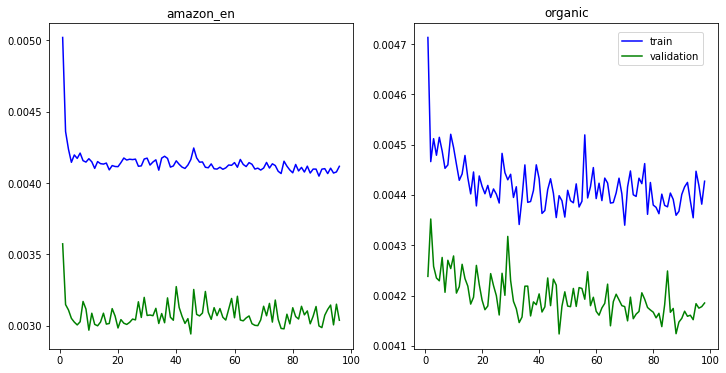

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon_en, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon_en, amazon_train_losses,
            amazon_val_losses)
plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/xling_{params.classes_nb}cl')

<All keys matched successfully>

In [43]:
milnet = model.MilNet(params, train_embeddings=False).to(device)
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/xling_no_finetune_{params.classes_nb}cl'))

<All keys matched successfully>

In [44]:
def get_results(full_set, nb_runs):
  results = []
  n = len(full_set)
  for _ in range(nb_runs):
    _, test_set = utils.data.random_split(full_set, [n - n //10, n//10])
    test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                        shuffle=True,
                                        collate_fn=prepare_batch,
                                        drop_last=True)
    for documents, classes in test_loader:
      predictions = milnet(documents).cpu().numpy()
      results.append((np.argmax(predictions, axis=1), classes.cpu().numpy()))
  
  return results

AMAZON_EN = 'amazon_en'
AMAZON_DE = 'amazon_de'
ORGANIC = 'organic'
results = {}
nb_runs = 40


milnet.eval()
with torch.set_grad_enabled(False):
  for name, full_set in datasets.items():
    results[name] = get_results(full_set, nb_runs)

In [41]:
for dataset_name, run_result in results.items():
  worst_f1 = float('inf')
  mean_f1 = 0
  top1 = None
  labels = None
  for run_top1, run_labels in run_result:
    run_micro = metrics.f1_score(run_labels, run_top1, average="micro")
    run_macro = metrics.f1_score(run_labels, run_top1, average="macro")
    run_f1 = run_micro + run_macro

    mean_f1 += run_f1

    if run_f1 < worst_f1:
      worst_f1 = run_f1
      top1 = run_top1
      labels = run_labels

  print(f'=== {dataset_name} ===')
  print(f'mean F1-score = {mean_f1/nb_runs/2}, worst F1-score = {worst_f1/2}')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
mean F1-score = 0.8389870073071307, worst F1-score = 0.8087033557991038
F1-micro = 0.8134556574923547
F1-macro = 0.8039510541058529

         n    p
    n   97   36
    p   25  169

=== amazon_de ===
mean F1-score = 0.8391250525440922, worst F1-score = 0.819333158359876
F1-micro = 0.8193384223918575
F1-macro = 0.8193278943278943

         n    p
    n  325   73
    p   69  319

=== organic ===
mean F1-score = 0.6894756400374734, worst F1-score = 0.642017691994223
F1-micro = 0.6430868167202572
F1-macro = 0.6409485672681887

         n    p
    n   88   54
    p   57  112

